# Import des librairies

San sebastien (Donostia)

In [8]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Chargement et inspection des données

In [2]:
# Charger les données
df = pd.read_csv("data_passagers.csv")

In [3]:
print(df.shape)

(37621, 5)


Ce jeu de données contient 37621 lignes et 5 colonnes.

In [4]:
# Afficher la description générale des données
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37621 entries, 0 to 37620
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dateTime          37621 non-null  object
 1   weather           37621 non-null  int64 
 2   lineNumber        37621 non-null  int64 
 3   passengersNumber  37621 non-null  int64 
 4   lineType          37621 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.4+ MB
None


Nous avons au total 37621 lignes de données.
Les attributs de ce jeu de données sont:


*   dateTime
*   weather
*   lineNumber
*   passengersNumber
*   lineType

In [5]:
# Afficher les 5 premières lignes des données
display(df.head())

,dateTime,weather,lineNumber,passengersNumber,lineType
0,2019-04-05,26,29,3032,daily
1,2019-04-05,26,42,418,daily
2,2019-04-05,26,40,2065,daily
3,2019-04-05,26,104,115,night
4,2019-04-05,26,27,2900,daily


In [6]:
# Afficher les statistiques descriptives des données
display(df.describe())

,weather,lineNumber,passengersNumber
count,37621.000000,37621.000000,37621.000000
mean,24.010579,31.744903,2067.940990
std,11.734847,23.335248,2494.733418
min,11.000000,5.000000,1.000000
25%,13.000000,17.000000,365.000000
50%,24.000000,28.000000,1241.000000
75%,26.000000,38.000000,2558.000000
max,62.000000,110.000000,16124.000000


In [7]:
print(df['lineNumber'].nunique())

39


# Y'a-t-il des valeurs manquantes ?

Nombre de valeurs manquantes par colonne :

dateTime            0
weather             0
lineNumber          0
passengersNumber    0
lineType            0
dtype: int64

Pourcentage de valeurs manquantes par colonne :

dateTime            0.0
weather             0.0
lineNumber          0.0
passengersNumber    0.0
lineType            0.0
dtype: float64


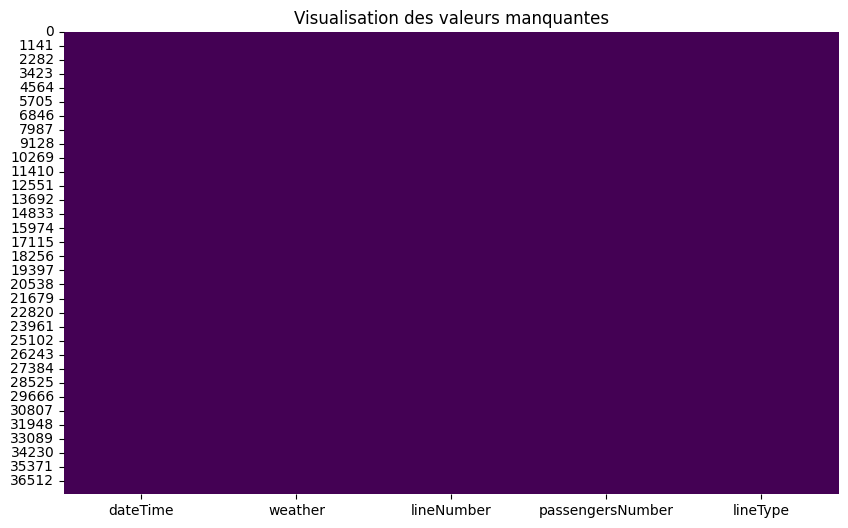

In [9]:
# Aperçu du nombre de valeurs manquantes par colonne
missing_values = df.isnull().sum()

print("Nombre de valeurs manquantes par colonne :\n")
print(missing_values)

# Pourcentage de valeurs manquantes par colonne
missing_percentage = (df.isnull().sum() / len(df)) * 100

print("\nPourcentage de valeurs manquantes par colonne :\n")
print(missing_percentage)

# Visualisation rapide avec un heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Visualisation des valeurs manquantes")
plt.show()

Il n'y a aucune valeur manquante dans ce dataset.

# Data Visualisation

## Saisonnalité en fonction des périodes

### Visualisation de la saisonnalité globale

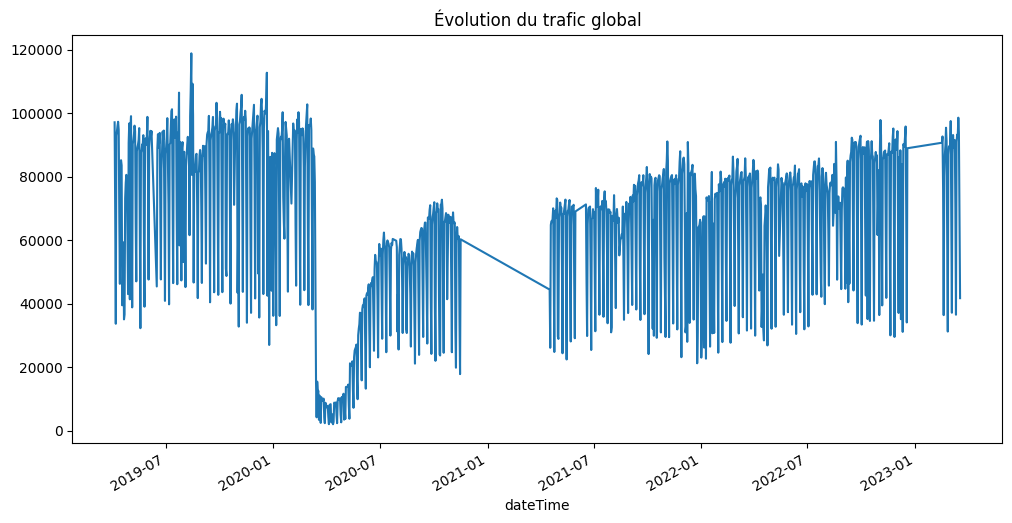

In [10]:
# Transformation de la date à bonne structuration
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d')

df.groupby('dateTime')['passengersNumber'].sum().plot(figsize=(12,6))
plt.title("Évolution du trafic global")
plt.show()

On constate des gap.

La cause est probablement un manque de dates dans le dataset.

Le pic descendant quant à lui correspond à la période de covid.

### Exploration des dates manquantes

In [11]:
# Création de la plage de dates complète (du début à la fin du dataset)
full_range = pd.date_range(start=df['dateTime'].min(), end=df['dateTime'].max(), freq='D')

# Identification des dates qui ne sont pas dans le DataFrame
# Transformation des dates du DF en set pour une comparaison rapide
existing_dates = pd.to_datetime(df['dateTime']).dt.normalize().unique()
missing_dates = full_range[~full_range.isin(existing_dates)]

print(f"Nombre de jours totalement absents du dataset : {len(missing_dates)}")
print("Exemples de dates manquantes :")
print(missing_dates[:10])

Nombre de jours totalement absents du dataset : 258
Exemples de dates manquantes :
DatetimeIndex(['2019-04-09', '2019-06-08', '2019-06-09', '2019-06-10', '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14', '2019-06-15', '2019-07-05'], dtype='datetime64[ns]', freq=None)


In [12]:
missing_df = pd.DataFrame(missing_dates, columns=['date'])
missing_df['year_month'] = missing_df['date'].dt.to_period('M')

# Nombre de jours manquent par mois
missing_counts = missing_df.groupby('year_month').size()
print("Nombre de jours manquants par mois :")
print(missing_counts[missing_counts > 0])

Nombre de jours manquants par mois :
year_month
2019-04     1
2019-06     8
2019-07     1
2019-10     1
2020-01     3
2020-02     2
2020-07     5
2020-09     2
2020-10     1
2020-11    14
2020-12    31
2021-01    31
2021-02    28
2021-03    31
2021-04    16
2021-06    17
2021-08     1
2021-10     1
2022-05     3
2022-07     1
2022-09     1
2022-10     1
2022-12    12
2023-01    31
2023-02    15
Freq: M, dtype: int64


### Saisonnalité par année

In [14]:
df['day_of_week'] = df['dateTime'].dt.day_name()
df['month'] = df['dateTime'].dt.month
df['year'] = df['dateTime'].dt.year

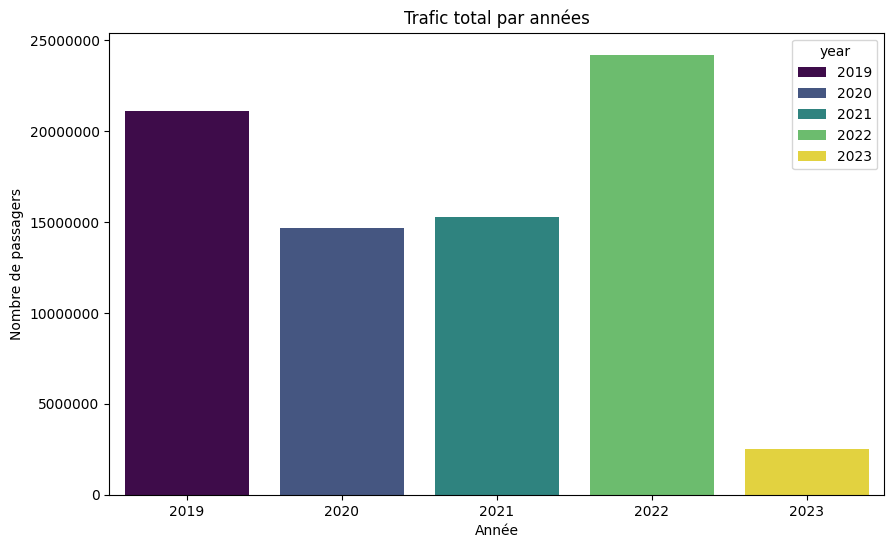

In [15]:
df_year_traffic = df.groupby('year')['passengersNumber'].sum()

# Ordonner les années dans l'ordre croissant
df_year_traffic = df_year_traffic.sort_index()


# Créer le graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=df_year_traffic.index, y=df_year_traffic.values, palette='viridis', hue= df_year_traffic.index)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par années")
plt.xlabel("Année")
plt.ylabel("Nombre de passagers")
plt.show()

* On remarque une **baisse de fréquentation** pour les années **2020** et **2021**. Cela est sûrement dû au covid et aux données manquantes. Il faudrait une analyse plus approfondie de ces données.
* Le taux de fréquentation pour l'année **2023** est le plus faible car les données pour cette année ne vont qu'au mois de **Mars** et certaines dates sont manquantes.

### Saisonnalité par mois

/tmp/ipykernel_2827/2287454948.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_month_traffic.index, y=df_month_traffic.values, palette='viridis')


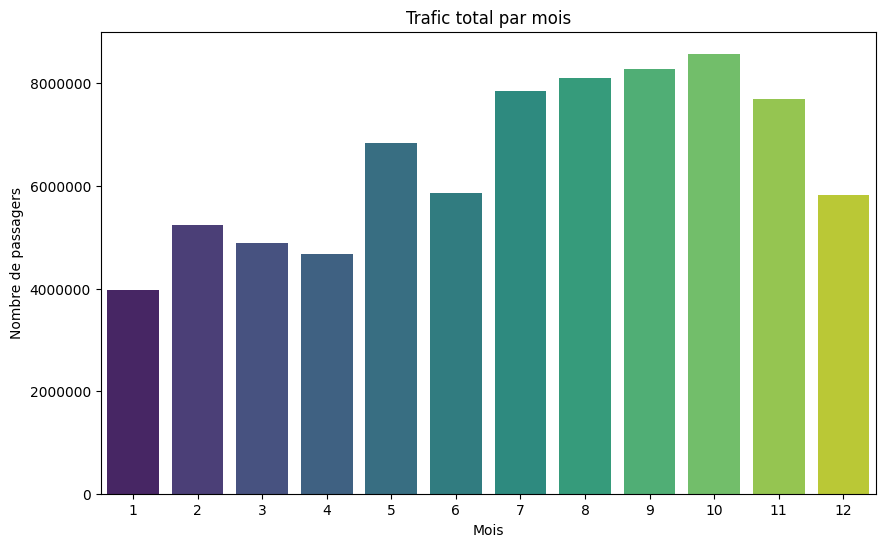

In [17]:
df_month_traffic = df.groupby('month')['passengersNumber'].sum()

# Ordonner les années dans l'ordre croissant
df_month_traffic = df_month_traffic.sort_index()
df_month = df['month'].nunique()
# Créer le graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=df_month_traffic.index, y=df_month_traffic.values, palette='viridis')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de passagers")
plt.show()

- On observe une croissance constante du trafic de janvier à Avril, avec une montée en Mai (peut être du à la fin de l'hiver). ensuite une hausse de juillet à octobre avec un pic marqué en octobre (plus de 8 millions de passagers cumulés).

- Le mois d'août est élevé (tourisme + Semana Grande), mais la rentrée d'octobre est encore plus forte. Le creux de décembre/janvier correspond aux vacances de fin d'année.

### Saisonnalité par semaine

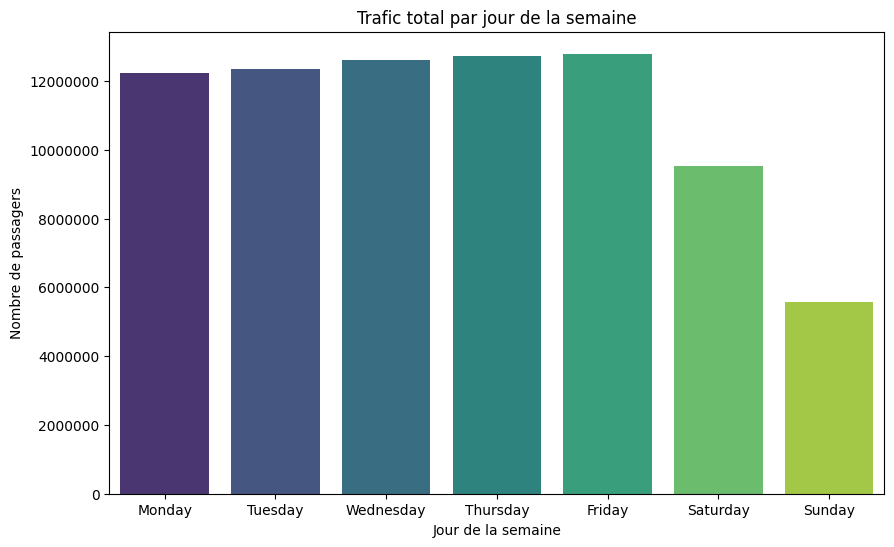

In [18]:
df_daily_traffic = df.groupby('day_of_week')['passengersNumber'].sum()

# Ordonner les jours de la semaine pour une meilleure visualisation
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_daily_traffic = df_daily_traffic.reindex(day_order)

# Créer le graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=df_daily_traffic.index, y=df_daily_traffic.values, palette='viridis',hue= day_order)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre de passagers")
plt.show()

* Nous remarquons une certaine **saisonnalité** avec **une baisse de fréquentation** durant **les weekends**.
Cela est du au fait que les week-ends sont des jours non ouvrables.

## Distribution des passagers par type de ligne

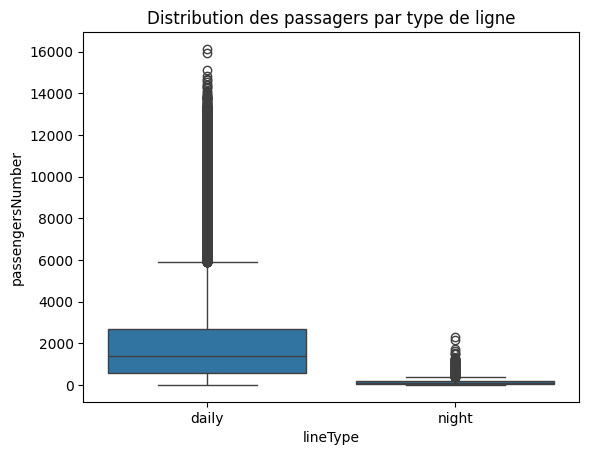

In [19]:
# Visualisation de la distribution des passagers par type de ligne (Dayline vs Nightline)
sns.boxplot(x='lineType', y='passengersNumber', data=df)
plt.title("Distribution des passagers par type de ligne")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Les lignes de bus de **jour** sont beaucoup plus fréquentées que celles de **nuit**.

## Distribution des lignes par type

/tmp/ipykernel_2827/3379430066.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=line_distribution, x='lineType', y='nb_lignes', palette='viridis')


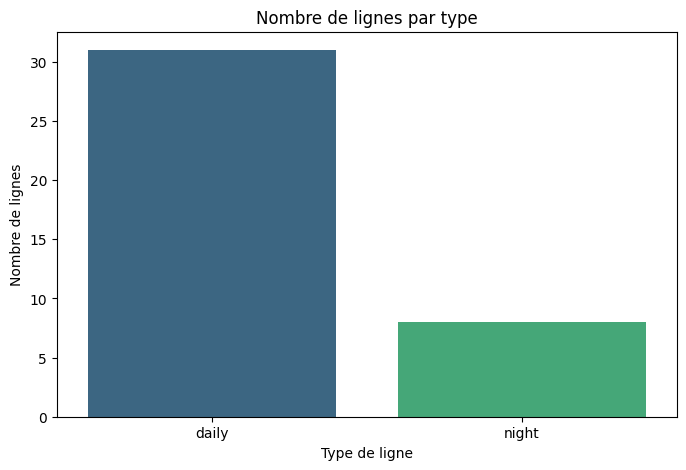

In [20]:
# Groupby lineType et compter le nombre de lignes
line_distribution = df.groupby('lineType')['lineNumber'].nunique().reset_index()

# Renommer les colonnes pour plus de clarté
line_distribution.columns = ['lineType', 'nb_lignes']

# Visualisation de la distribution des lignes par type
plt.figure(figsize=(8,5))
sns.barplot(data=line_distribution, x='lineType', y='nb_lignes', palette='viridis')

plt.title("Nombre de lignes par type")
plt.xlabel("Type de ligne")
plt.ylabel("Nombre de lignes")
plt.show()

Il y a au 31 lignes de jour et 8 de nuit.

### Trafic pour les lignes de jour

/tmp/ipykernel_2827/736284322.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily_shift, x='lineNumber', y='passengersNumber', palette='magma')


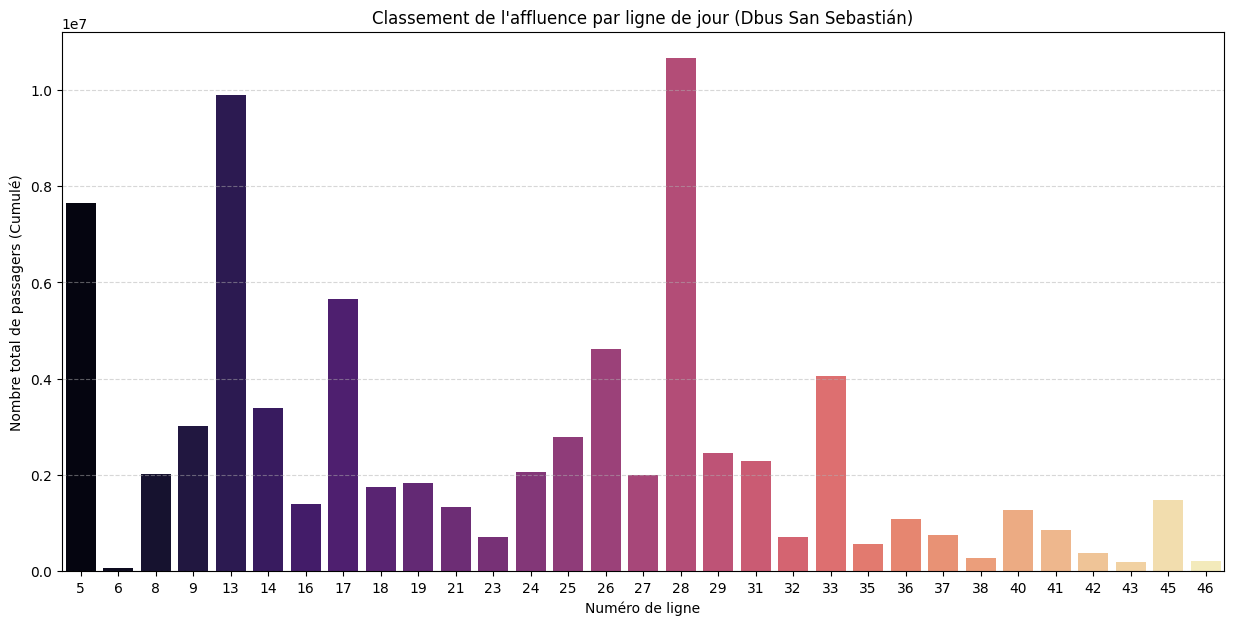

In [21]:
# Filtrer uniquement les lignes de nuit
df_day = df[df['lineType'] == 'daily']

# 2. Grouper par ligne pour obtenir l'affluence totale
# On utilise la somme pour voir quelles lignes transportent le plus de monde
daily_shift = df_day.groupby('lineNumber')['passengersNumber'].sum().reset_index()

# 4. Visualisation
plt.figure(figsize=(15, 7)) # On élargit car il y a beaucoup de lignes
sns.barplot(data=daily_shift, x='lineNumber', y='passengersNumber', palette='magma')

plt.title("Classement de l'affluence par ligne de jour (Dbus San Sebastián)")
plt.xlabel("Numéro de ligne")
plt.ylabel("Nombre total de passagers (Cumulé)")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Les lignes 28 et 13 sont les plus fréquentées. La 6 est la moins fréquentée.
- Ligne 28 (Amara - Ospitaleak) : C'est la ligne la plus fréquentée, dépassant les 10 millions de passagers. Sa position dominante s'explique par le fait qu'elle dessert le quartier très dense d'Amara et le complexe hospitalier, le principal pôle de santé de la province.

- Ligne 13 (Altza) : Avec près de 10 millions de passagers, c'est la deuxième ligne majeure. Elle relie le centre-ville au quartier d'Altza, l'un des plus peuplés et éloignés du centre.

les lignes 5, 17, 26 et 33 demeurrent significatives 
- Ligne 5 (Benta Berri) : Très fréquentée car elle dessert le quartier universitaire et le quartier d'Antiguo.

- Ligne 17 (Gros - Amara - Miramon) : Une ligne transversale importante.

- Ligne 26 (Amara - Martutene) : Un axe sud essentiel.

- Ligne 33 (Larratxo - Intxaurrondo - Antiguo - Berio) : Une ligne "ceinture" qui connecte les quartiers entre eux sans passer forcément par l'hyper-centre.

les autres lignes representent: 
- Les lignes de proximité (microbus) ou de lignes desservant des zones de faible densité (collines comme Igeldo ou Ulia).
La ligne 6, par exemple, est historiquement une ligne avec peu de fréquentation comparée aux grands axes radiaux car c'est une ligne microbus qui fonctionnent uniquement sous réservation.

### Trafic pour les lignes de nuit

/tmp/ipykernel_2827/2425584046.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=night_shift, x='lineNumber', y='passengersNumber', palette='viridis')


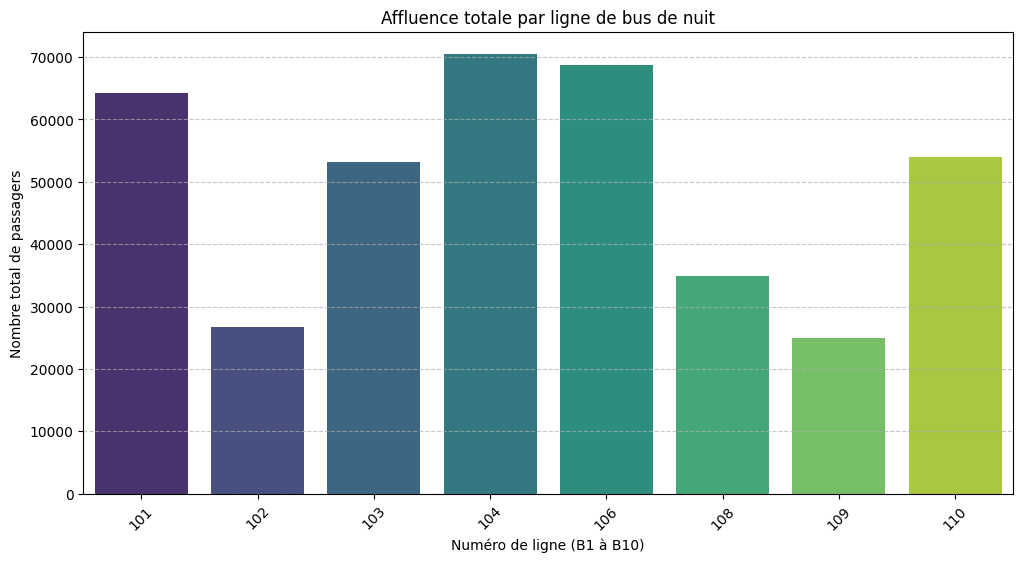

In [22]:
# Filtrer uniquement les lignes de nuit
df_night = df[df['lineType'] == 'night']

night_shift = df_night.groupby('lineNumber')['passengersNumber'].sum().reset_index()

# 3. Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(data=night_shift, x='lineNumber', y='passengersNumber', palette='viridis')

plt.title("Affluence totale par ligne de bus de nuit")
plt.xlabel("Numéro de ligne (B1 à B10)")
plt.ylabel("Nombre total de passagers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- On retrouve la même logique que sur le premier graphique : les quartiers d'Altza 106 (B6) et d'Amara 104 (B4) restent les moteurs principaux du transport public, que ce soit à 14h ou à 4h du matin.

## Trafic par numéro de ligne

/tmp/ipykernel_2827/1731741911.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lines.index, y=lines.values, palette="viridis")


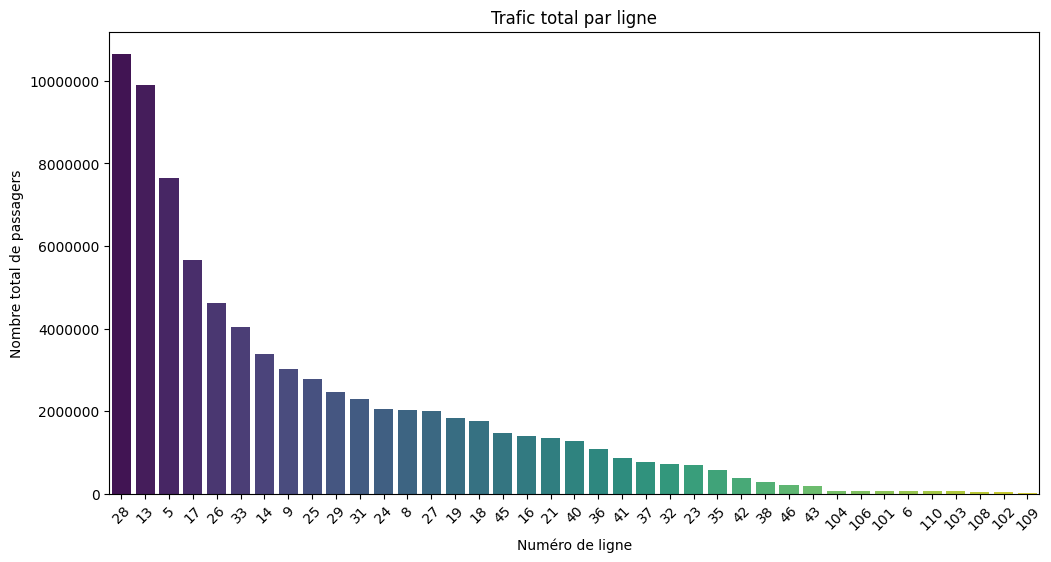

In [23]:
df_line_traffic = df.groupby('lineNumber')['passengersNumber'].sum()

# Tri décroissant et sélection du top 20
lines = df_line_traffic.sort_values(ascending=False)

# Conversion en string pour éviter l'ordre numérique
lines.index = lines.index.astype(str)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=lines.index, y=lines.values, palette="viridis")

plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par ligne")
plt.xlabel("Numéro de ligne")
plt.ylabel("Nombre total de passagers")
plt.xticks(rotation=45)
plt.show()

Comme on l'a dit plus haut les lignes 28 et 13 representent le coeur du réseau urbain de san sebastian. elles sont suivis par d'autres lignes structurantes tels que la 5, 17, 26 et la 33. Quant aux autres on est sois sur des lignes spéciales (la 6) des lignes qui desservent des zones peu peuplées ainsi que les lignes de nuit.


## Corrélation des variables

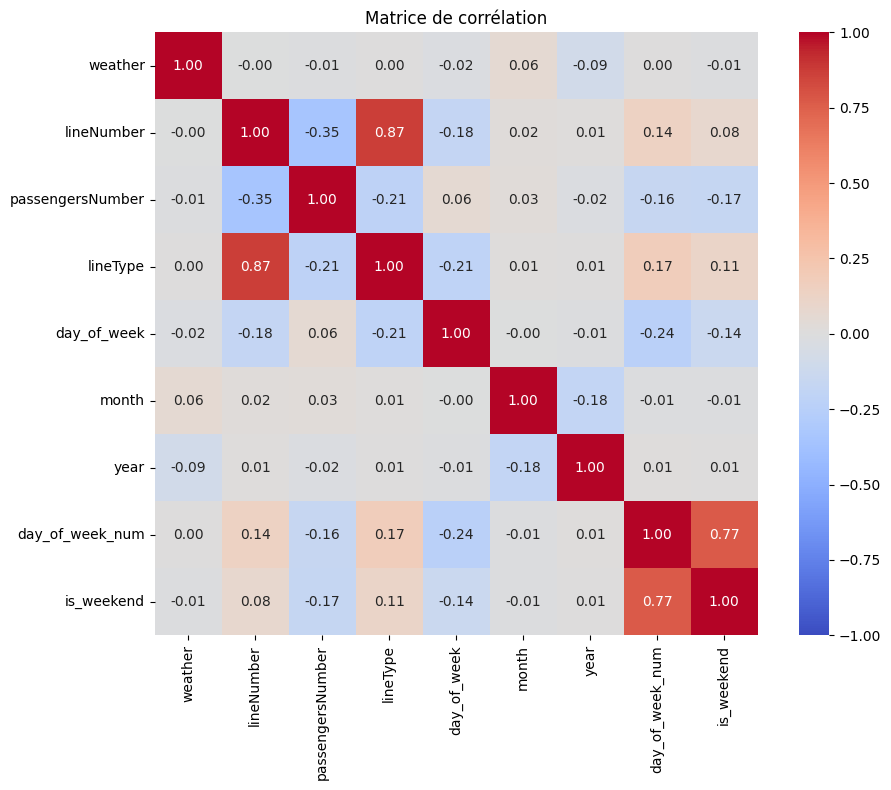

In [28]:
# Matrice de corrélation par rapport à la target passengersNumber

# Préparer une copie pour ne pas modifier le df original
df_corr = df.copy()

for col in ['date', 'dateTime', 'year_month']:
    if col in df_corr.columns:
        df_corr = df_corr.drop(columns=[col])

# Encoder les variables catégorielles en codes numériques pour la corrélation
for col in ['lineType', 'day_of_week']:
    if col in df_corr.columns:
        df_corr[col] = df_corr[col].astype('category').cat.codes

df_corr['lineNumber'] = df_corr['lineNumber'].astype('category')

# Calculer la matrice de corrélation
corr_matrix = df_corr.corr()


# Afficher la heatmap des corrélations (incluant la target)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

* **lineNumber** Corrélation négative modérée : certaines lignes de bus ont moins de passagers que d’autres. Le numéro de ligne est donc un facteur discriminant.
* **lineType** Corrélation négative faible à modérée : le type de ligne (ex. urbaine vs interurbaine) influence le nombre de passagers.

- Les variables lineNumber et lineType sont les plus explicatives (elles différencient les lignes en termes d’affluence).
- Les variables temporelles simples (day_of_week, month, year) n’expliquent pas beaucoup à elles seules.
- La météo telle que codée actuellement n’apporte pas d’information (il faudrait peut-être la transformer en catégories plus pertinentes).

**Il n'y a pas de corrélation linéaire forte en les features actuelles et la variable cible**

## Feature engineering

### Encodage de day_of_week, is_weekend

In [26]:
df['day_of_week_num'] = df['dateTime'].dt.dayofweek
df['is_weekend'] = df['day_of_week_num'].isin([5,6]).astype(int)

In [27]:
print(df.sample(10))

        dateTime  weather  lineNumber  passengersNumber lineType day_of_week  month  year  day_of_week_num  is_weekend
1585  2019-05-23       43          19              1612    daily    Thursday      5  2019                3           0
30615 2022-06-20       26          32               696    daily      Monday      6  2022                0           0
16952 2020-11-02       23          36               863    daily      Monday     11  2020                0           0
28576 2022-04-16       14          13              7047    daily    Saturday      4  2022                5           1
13425 2020-07-07       12          31              1821    daily     Tuesday      7  2020                1           0
30695 2022-06-22       25          25              2556    daily   Wednesday      6  2022                2           0
18223 2021-05-14       23          24              2082    daily      Friday      5  2021                4           0
23084 2021-10-30       26         102           

### Encodage de lineType

In [29]:
df['lineType'] = df['lineType'].astype('category').cat.codes # 0 pour Daily, 1 pour Night

In [30]:
print(df.head())

    dateTime  weather  lineNumber  passengersNumber  lineType day_of_week  month  year  day_of_week_num  is_weekend
0 2019-04-05       26          29              3032         0      Friday      4  2019                4           0
1 2019-04-05       26          42               418         0      Friday      4  2019                4           0
2 2019-04-05       26          40              2065         0      Friday      4  2019                4           0
3 2019-04-05       26         104               115         1      Friday      4  2019                4           0
4 2019-04-05       26          27              2900         0      Friday      4  2019                4           0


#### Encodage de weather

In [32]:
weather_mapping = {
    # Famille 1: très pluvieux
    25: 1, 53: 1, 52: 1, 61: 1, 62: 1,
    # Famille 2: pluvieux
    12: 2, 24: 2, 26: 2, 45: 2, 46: 2, 51: 2,
    # Famille 3: Très nuageux
    13: 3, 14: 3, 15: 3, 16: 3, 23: 3, 43: 3,
    # Famille 4 : Partiellement nuageux
    17: 4, 44: 4,
    # Famille 5: Ensoleillé
    11: 5
}

df['weather_family'] = df['weather'].map(weather_mapping)

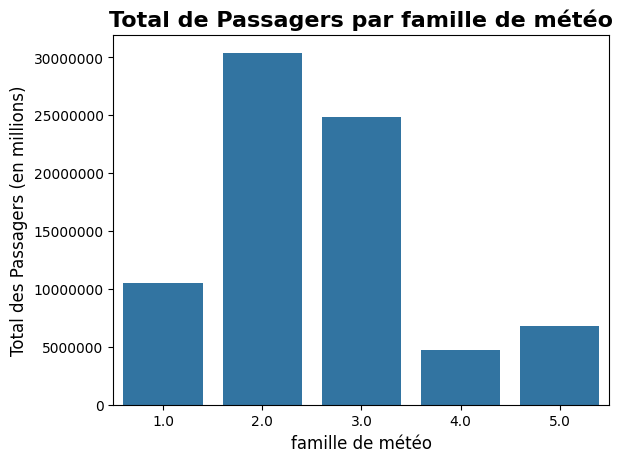

In [36]:
passengers_by_weather =df.groupby('weather_family')['passengersNumber'].sum().reset_index()
passengers_by_weather.columns = ['weather_family', 'passengers']

ax =sns.barplot(
    x='weather_family',
    y='passengers',
   data=passengers_by_weather
    
)
ax.ticklabel_format(style='plain',axis='y')


plt.title('Total de Passagers par famille de météo', fontsize=16, fontweight='bold')
plt.xlabel('famille de météo', fontsize=12)
plt.ylabel('Total des Passagers (en millions)', fontsize=12)
plt.show()

On voit que les catégories 2.0 et 3.0 (pluvieux/nuageux) dominent largement. L'interprétation est simple : il ne s'agit pas d'une préférence des usagers, mais de la météo habituelle de San Sebastián. C'est là qu'il y a le plus de jours cumulés.

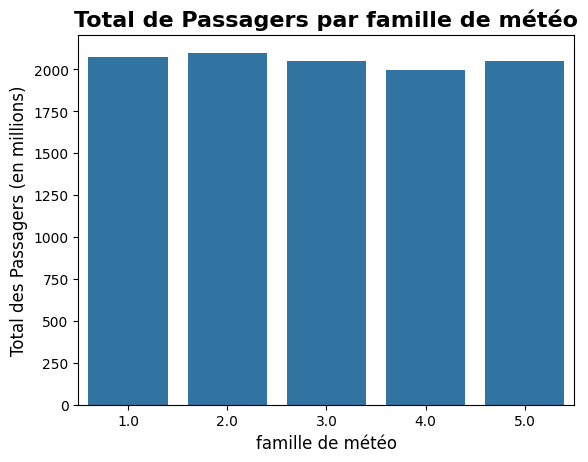

In [35]:
passengers_by_weather =df.groupby('weather_family')['passengersNumber'].mean().reset_index()
passengers_by_weather.columns = ['weather_family', 'passengers']

ax =sns.barplot(
    x='weather_family',
    y='passengers',
   data=passengers_by_weather
    
)
ax.ticklabel_format(style='plain',axis='y')


plt.title('Total de Passagers par famille de météo', fontsize=16, fontweight='bold')
plt.xlabel('famille de météo', fontsize=12)
plt.ylabel('Total des Passagers (en millions)', fontsize=12)
plt.show()

Les barres sont presque au même niveau (autour de 2000 passagers/jour).
On retient alors que Bien que la ville soit majoritairement pluvieuse, la moyenne quotidienne de passagers reste stable quelle que soit la météo. Cela indique que le transport est dicté par des besoins structurels (travail, études) plutôt que par le climat.

la variable weather ne fera donc pas parti des features pour l'entrainement des modèles.

### Ajout d'une variable is_holiday

In [37]:
import holidays as hd

In [38]:
es_holidays = hd.Spain(subdiv="PV", years=range(2019,2024))

df["is_holiday"] = df['dateTime'].isin(es_holidays).astype(int)

display(df[['is_holiday','dateTime']])

/tmp/ipykernel_2827/915818206.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df['dateTime'].isin(es_holidays).astype(int)


,is_holiday,dateTime
0,0,2019-04-05
1,0,2019-04-05
2,0,2019-04-05
3,0,2019-04-05
4,0,2019-04-05
...,...,...
37616,0,2023-03-19
37617,0,2023-03-19
37618,0,2023-03-19
37619,0,2023-03-19


### Ajout d'une variable is_tamborrada(san sebastian day)

In [39]:
# Ajout de la San Sebastián Day
custom_dates = ['2023-01-20', '2022-01-20','2021-01-20','2020-01-20','2019-01-20']
df['is_tamborrada'] = df['dateTime'].dt.strftime('%Y-%m-%d').isin(custom_dates).astype(int)

display(df[['is_tamborrada','dateTime']])

,is_tamborrada,dateTime
0,0,2019-04-05
1,0,2019-04-05
2,0,2019-04-05
3,0,2019-04-05
4,0,2019-04-05
...,...,...
37616,0,2023-03-19
37617,0,2023-03-19
37618,0,2023-03-19
37619,0,2023-03-19


In [40]:
total_tamborrada = df[df['is_tamborrada'] == 1].groupby('dateTime')['passengersNumber'].sum().reset_index()

print("Trafic total cumulé (toutes lignes) pour la Tamborrada :")
display(total_tamborrada)

Trafic total cumulé (toutes lignes) pour la Tamborrada :


,dateTime,passengersNumber
0,2020-01-20,60445
1,2022-01-20,30644


la tamborrada est le jour de la fête de Saint Sebastien et ce jour est vraiment célébré par les habitants.

### Ajout d'une variable is_semana_grande

La semana grande est une semaine festivependant le mois d'août qui enregistre en général de grandes affluences.

In [41]:
semana_grande_dates = {
    2019: ('2019-08-10', '2019-08-17'),
    2020: (None, None), # Annulée à cause du COVID
    2021: (None, None), # Annulée à cause du COVID
    2022: ('2022-08-13', '2022-08-20'),
    2023: ('2023-08-12', '2023-08-19')
}

def is_semana_grande(dt):
    year = dt.year
    if year not in semana_grande_dates:
        return 0
    start, end = semana_grande_dates[year]
    if start and end:
        if pd.to_datetime(start) <= dt <= pd.to_datetime(end):
            return 1
    return 0


# Application sur ton DataFrame complet (57 000 lignes)
df['is_semana_grande'] = df['dateTime'].apply(is_semana_grande)

### Ajout d'une variable is_match_day 

La ville de San Sebastian se caractérise par son amour pour le foot notamment grace à son célèbre club de foot la Real Sociedad. Les jours de  match à domicile pourraient donc permettre au modèle de réaliser de meilleures prédictions.

In [42]:
match_day = ['2019-04-14', '2019-04-25', '2019-04-28',
'2019-05-12', '2021-08-22','2021-08-28','2021-09-19','2021-09-26','2021-09-30','2021-10-16','2021-10-31','2021-11-04','2021-11-21','2021-12-04',
'2021-12-09','2021-12-18','2022-01-08','2022-01-19','2022-01-23','2022-02-03','2022-02-13','2022-02-24','2022-02-27','2022-03-13','2022-04-04',
'2022-04-15','2022-04-21','2022-05-12','2022-05-22','2022-08-21','2022-09-08','2022-09-15','2022-09-18','2022-10-09','2022-10-13','2022-10-19',
'2022-10-30','2022-11-03','2022-11-06','2022-12-31','2023-01-14','2023-01-17','2023-02-05','2023-02-18','2023-03-03','2023-03-16','2023-03-19']

df['is_match_day'] = df['dateTime'].dt.strftime("%Y-%m-%d").isin(match_day).astype(int)

### Lags, Moyennes Mobiles et Ecart-type mobile 

Dans Nos données d'origine, on n'a des dates qui manquent. Or, pour calculer un Lag (ce qui s'est passé hier) ou une Moyenne Mobile (ce qui s'est passé les 7 derniers jours), l'algorithme a besoin d'une suite mathématique non interrompue.

Si on passes du vendredi au lundi (parce qu'il manque le samedi et le dimanche dans nos données), pour l'ordinateur, "hier" devient le vendredi. Or, le trafic d'un lundi ne ressemble pas à celui d'un samedi.

Nous allons éviter ce problème en créant un calendrier complet (toutes les dates de 2019 à 2023), garantissant que J-1 est bien le jour calendaire précédent. Cela permet de calculer des moyennes sur de "vraies" semaines de 7 jours, ce qui est crucial pour capter les cycles de transport.

In [43]:
df['is_real_data'] = 1

In [44]:
# 1. Définir la plage de dates complète
all_dates = pd.date_range(start='2019-04-05', end='2023-03-19', freq='D')

# 2. Récupérer la liste unique de tes lignes de bus
all_lines = df['lineNumber'].unique()

# 3. Créer le produit cartésien (chaque date pour chaque ligne)
full_index = pd.MultiIndex.from_product([all_dates, all_lines], names=['dateTime', 'lineNumber'])
df_grid = pd.DataFrame(index=full_index).reset_index()

In [45]:
# Fusion "Left Join" : on garde toute la grille et on remplit avec ce qu'on a
df_final = pd.merge(df_grid, df, on=['dateTime', 'lineNumber'], how='left')

In [50]:
# 2. PREMIER PASSAGE : Médiane par Ligne ET par Jour de la semaine (Précis)
df_final['passengersNumber'] = df_final.groupby(['lineNumber', 'day_of_week'])['passengersNumber'].transform(
    lambda x: x.fillna(x.median())
)

# 3. DEUXIÈME PASSAGE : S'il reste des NaN, Médiane par Ligne uniquement (Général)
# Cela arrive si une ligne n'a JAMAIS eu de données pour un jour précis (ex: jamais de dimanche)
df_final['passengersNumber'] = df_final.groupby('lineNumber')['passengersNumber'].transform(
    lambda x: x.fillna(x.median())
)

# 4. TROISIÈME PASSAGE : Si une ligne est totalement vide (très rare)
# On remplit par la médiane de tout le réseau
df_final['passengersNumber'] = df_final['passengersNumber'].fillna(df_final['passengersNumber'].median())

In [51]:
# Conversion avant de faire les ffill/bfill
df_final['lineNumber'] = df_final['lineNumber'].astype(str)

df_final = df_final.sort_values(['lineNumber', 'dateTime'])
# ffill (Forward Fill) propage la dernière valeur connue vers le bas
# bfill (Backward Fill) propage vers le haut pour les premières lignes
df_final['lineType'] = df_final.groupby('lineNumber')['lineType'].ffill().bfill()

### Calcul des lags

In [54]:
df_final = df_final.sort_values(by=['lineNumber','dateTime'])
df_final['passengersNumber_of_yesterday'] = df_final.groupby('lineNumber')['passengersNumber'].shift(1)
df_final['passengersNumber_of_two_days_ago'] = df_final.groupby('lineNumber')['passengersNumber'].shift(2)
df_final['passengersNumber_of_three_days_ago'] = df_final.groupby('lineNumber')['passengersNumber'].shift(3)

# Trafic à la même heure/jour la semaine dernière
df_final['passengers_J_minus_7'] = df_final.groupby('lineNumber')['passengersNumber'].shift(7)
# Trafic il y a 2 semaines (optionnel mais utile)
df_final['passengers_J_minus_14'] = df_final.groupby('lineNumber')['passengersNumber'].shift(14)

In [55]:
# Moyenne mobile sur 7 jours (rolling mean)
df_final['moyenne_traffic_sur_7j'] = (
    df.groupby('lineNumber')['passengersNumber']
      .shift(1)  # décalage pour ne pas inclure le jour courant
      .rolling(window=7)
      .mean()
)

# Moyenne mobile sur 7 jours (rolling mean)
df_final['moyenne_traffic_sur_30j'] = (
    df.groupby('lineNumber')['passengersNumber']
      .shift(1)  # décalage pour ne pas inclure le jour courant
      .rolling(window=30)
      .mean()
)

# Écart-type mobile sur 7 jours (rolling std)
df_final['ecart_type_traffic_sur_7j'] = (
      df.groupby('lineNumber')['passengersNumber']
        .shift(1)
        .rolling(window=7)
        .std()
  )

# Écart-type mobile sur 30 jours (rolling std)
df_final['ecart_type_traffic_sur_30j'] = (
    df.groupby('lineNumber')['passengersNumber']
      .shift(1)
      .rolling(window=30)
      .std()
)

Retour aux données de base c'est à dire les dates qu'on avait à la base 

In [90]:
# On ne garde que les lignes où les passagers n'étaient pas des NaN à l'origine
df_final1= df_final[df_final['is_real_data'] == 1].copy()



In [91]:
df_final1.shape

(37621, 25)

### Encodage de lineNumber

Nous allons utiliser le M-Estimate Encoding pour transformer les variables catégorielles (lignes de bus) en valeurs numériques basées sur la probabilité de fréquentation. Cette méthode permet de conserver l'information hiérarchique du réseau (lignes fortes vs lignes faibles) tout en régularisant les données pour éviter le sur-apprentissage, ce qui est crucial pour stabiliser le RMSE sur un réseau hétérogène de 39 lignes.

In [ ]:
# 1. Liste des features validées par ton analyse de corrélation
features = [
    'lineNumber', 'lineType', 'is_weekend', 'is_holiday', 'is_tamborrada','is_semana_grande', 'is_match_day',
    'month', 'day_of_week_num',
    'passengers_J_minus_7', 'passengersNumber_of_yesterday',
    'moyenne_traffic_sur_7j', 'moyenne_traffic_sur_30j'
]

target = 'passengersNumber'


#Copie du dataset
df_customized=df_final1.copy()
# 3. Filtrage du dataset

In [124]:
# On définit les deux périodes saines
periode_2019 = (df_customized['dateTime'] >= '2019-01-01') & (df_customized['dateTime'] <= '2020-01-01')
periode_post_covid = (df_customized['dateTime'] >= '2021-07-01')

In [125]:
# On combine les deux avec un "OU" (|)
df_windowed = df_customized[periode_2019 | periode_post_covid].copy()

In [126]:
from category_encoders import MEstimateEncoder

# 1. Séparation temporelle (exemple : on teste sur 2023)
train_mask = (df_windowed['dateTime'] < '2023-02-01')
test_mask = (df_windowed['dateTime'] >= '2023-02-01')


df_train = df_windowed[train_mask]
df_test = df_windowed[test_mask]

# 4. Préparation des matrices pour XGBoost
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]


# 3. Application du M-Estimate
# m=5 est un bon compromis pour lisser les lignes avec peu de données
encoder = MEstimateEncoder(cols=['lineNumber'], m=5.0)

# On apprend les moyennes UNIQUEMENT sur le train
X_train_encoded = encoder.fit_transform(X_train, y_train)

# On applique ces moyennes au test (les données futures ne sont pas utilisées)
X_test_encoded = encoder.transform(X_test)

# Modelisation

### Baseline: XGBoost

In [113]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [127]:
# Initialiser le modèle XGBoost
model = xgb.XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

model.fit(X_train_encoded, y_train, eval_set=[(X_test_encoded, y_test)], verbose=100)

[0]	validation_0-rmse:2642.96615
[100]	validation_0-rmse:392.22870
[200]	validation_0-rmse:380.17427
[300]	validation_0-rmse:372.29423
[400]	validation_0-rmse:367.02497
[433]	validation_0-rmse:367.63244


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,True
,eval_metric,None


<Figure size 1000x800 with 0 Axes>

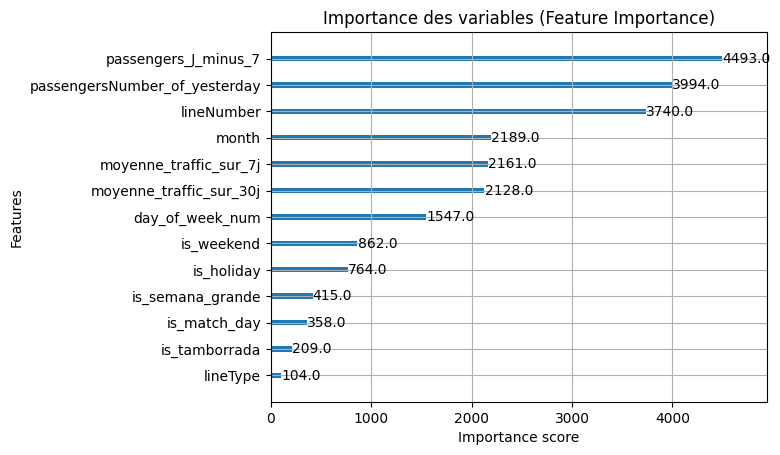

In [128]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=15)
plt.title("Importance des variables (Feature Importance)")
plt.show()

In [129]:
# Évaluation
y_pred_train = model.predict(X_train_encoded)
y_pred_test = model.predict(X_test_encoded)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Train -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R²: {r2_train:.4f}")
print(f"Test  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R²: {r2_test:.4f}")


Train -> MAE: 127.05, RMSE: 220.73, R²: 0.9927
Test  -> MAE: 195.79, RMSE: 366.88, R²: 0.9824


In [130]:
y_pred = model.predict(X_test_encoded)

# 2. Créer un DataFrame d'analyse (en utilisant l'index de X_test pour garder les dates)
analysis_df = pd.DataFrame({
    'dateTime': df_test['dateTime'], # On récupère les vraies dates
    'lineNumber': df_test['lineNumber'],
    'actual': y_test,
    'predicted': y_pred
})

# 3. Calculer l'erreur absolue et l'erreur au carré
analysis_df['abs_error'] = abs(analysis_df['actual'] - analysis_df['predicted'])
analysis_df['squared_error'] = (analysis_df['actual'] - analysis_df['predicted'])**2

# 4. Trier par erreur au carré (car tu optimises le RMSE !)
worst_predictions = analysis_df.sort_values(by='squared_error', ascending=False).head(20)

print("--- Top 20 des plus grosses erreurs (RMSE focus) ---")
print(worst_predictions[['dateTime', 'lineNumber', 'actual', 'predicted', 'abs_error']])

--- Top 20 des plus grosses erreurs (RMSE focus) ---
        dateTime lineNumber   actual     predicted    abs_error
56026 2023-03-11         33   7162.0   4001.626953  3160.373047
55214 2023-02-18         13  11407.0   8361.227539  3045.772461
55122 2023-02-16         17   7788.0   5306.339844  2481.660156
55136 2023-02-16         13  11175.0   8946.378906  2228.621094
55278 2023-02-20         17   7290.0   5496.362793  1793.637207
55161 2023-02-17         17   8053.0   6300.955078  1752.044922
55129 2023-02-16         33   5510.0   3834.176270  1675.823730
55151 2023-02-17         28  11816.0  10207.801758  1608.198242
55551 2023-02-27         17   8003.0   6502.434570  1500.565430
55463 2023-02-25         28   7106.0   8580.462891  1474.462891
56087 2023-03-13         28  11828.0  10404.175781  1423.824219
55541 2023-02-27         28  11536.0  10124.402344  1411.597656
55144 2023-02-16          5   8335.0   6932.172363  1402.827637
55356 2023-02-22         17   7916.0   6525.631348 